#  <center> Telecons + DLmath (CNN) </center>

## 1. Data Preparation

In [1]:
import os
import pandas as pd
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import cv2
import numpy as np
from torch.utils.data import Dataset
import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 2. Define the PyTorch Dataset 

In [2]:
# 데이터셋 정의
class VideoDataset(Dataset):
    def __init__(self, videos, labels, transform=None):
        self.videos = videos
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]  # (T, H, W, C)
        label = self.labels[idx]
        
        # 동영상 프레임 별로 전처리
        if self.transform:
            video = torch.stack([self.transform(frame) for frame in video])
        
        return video, label

## 3. CNN Model Design

In [3]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # CNN Layers
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 16

            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 4

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 4 -> 1
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(32, num_classes)
    
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape  # (batch_size, seq_len, channels, height, width)
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size, seq_len, -1)  # (batch_size, seq_len, feature_dim)
        x = x.mean(dim=1)  # Average pooling over the sequence dimension
        x = self.fc(x)  # Fully connected layer for classification
        return x

In [4]:
import os
import cv2
import numpy as np

def load_videos_split_frames(base_dir, folders, frame_size=(64, 64), num_frames=5):
    """
    동영상을 5등분하여 각 구간에서 1프레임씩 총 5프레임을 추출

    Parameters:
        base_dir (str): 동영상 폴더의 기본 디렉토리
        folders (list): 하위 폴더 리스트
        frame_size (tuple): 프레임 크기 (H, W)
        num_frames (int): 추출할 프레임 수 (기본값 5)

    Returns:
        videos (list): 영상 데이터 리스트 [(T, H, W, C)]
        labels (list): 라벨 리스트
    """
    videos, labels = [], []
    label_map = {"C1": 0, "C2": 1, "C5": 2}  # 클래스 라벨링

    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".gif"):
                    video_path = os.path.join(folder_path, file_name)
                    cap = cv2.VideoCapture(video_path)
                    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                    if total_frames >= num_frames:
                        step = total_frames // num_frames
                        selected_frames = []

                        for i in range(num_frames):
                            frame_idx = i * step
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                            ret, frame = cap.read()
                            if not ret:
                                break
                            frame = cv2.resize(frame, frame_size)
                            selected_frames.append(frame)

                        if len(selected_frames) == num_frames:
                            videos.append(np.array(selected_frames))  # (T, H, W, C)
                            labels.append(label_map[folder.split("_")[0]])

                    cap.release()
    return videos, labels

## 4. Data Loader

In [5]:
# 주요 파라미터 및 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/work/DLmath/Seulbin/Telecons/data/thermal_processed"
folders = ["C1_KNG_0207", "C1_SHM_0201", "C2_KNG_0207", "C2_SHM_0201_0229", "C5_SHM_0229"]
videos, video_labels = load_videos_split_frames(base_dir, folders)

# Train-Val-Test 분할
train_videos, temp_videos, train_labels, temp_labels = train_test_split(videos, video_labels, test_size=0.4, random_state=42)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, random_state=42)

# 데이터셋 및 데이터로더 생성
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = VideoDataset(train_videos, train_labels, transform)
val_dataset = VideoDataset(val_videos, val_labels, transform)
test_dataset = VideoDataset(test_videos, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

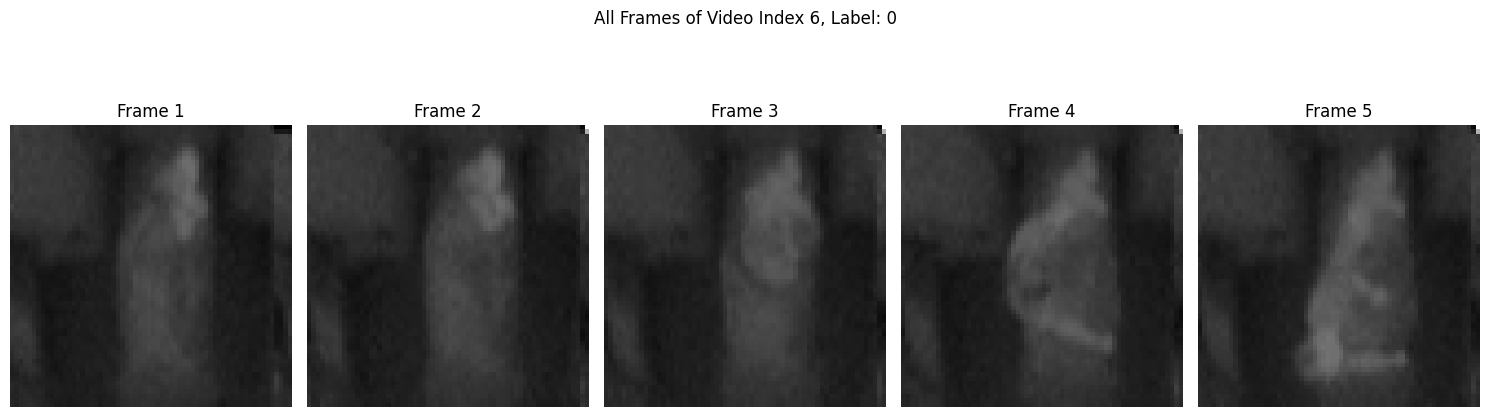

In [6]:
import matplotlib.pyplot as plt

def visualize_all_frames(dataset, idx=0):
    """
    데이터셋에서 주어진 인덱스의 비디오의 모든 프레임을 시각화합니다.
    
    Parameters:
        dataset: VideoDataset 객체
        idx: 시각화할 데이터 인덱스
    """
    video, label = dataset[idx]  # video: (T, C, H, W), label: int
    
    num_frames = video.shape[0]
    plt.figure(figsize=(15, 5))
    
    for i in range(num_frames):
        frame = video[i]  # (C, H, W)
        frame = frame.permute(1, 2, 0).numpy()  # (H, W, C)
        
        # Normalize된 데이터를 복원 (Transform 기준)
        frame = (frame * 0.5) + 0.5  # Transform Normalize(mean=0.5, std=0.5)
        
        # 각 프레임을 서브플롯에 출력
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.title(f"Frame {i+1}")
        plt.axis("off")
    
    plt.suptitle(f"All Frames of Video Index {idx}, Label: {label}")
    plt.tight_layout()
    plt.show()

# train_dataset에서 첫 번째 비디오의 모든 프레임 출력
visualize_all_frames(train_dataset, idx=6)

## 5. Training Loop

In [7]:
# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    best_model = None
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_preds, total_preds = 0, 0

        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # 정확도 계산
            _, preds = torch.max(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        train_acc = correct_preds / total_preds

        # Validation
        model.eval()
        val_loss = 0.0
        correct_preds, total_preds = 0, 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # 정확도 계산
                _, preds = torch.max(outputs, dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_preds / total_preds

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Best Model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            torch.save(best_model, "best_model.pth")
            print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    # 최종적으로 Best Model 로드
    if best_model:
        model.load_state_dict(best_model)
        print(f"Best model loaded with validation accuracy: {best_val_acc:.4f}")

    return model

# 테스트 함수
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    return acc

In [8]:
# 모델, 손실 함수, 옵티마이저 정의
model = CNNModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 학습 및 테스트
model = train_model(model, train_loader, val_loader, criterion, optimizer, device)

Epoch 1, Train Loss: 52.8499, Train Accuracy: 0.6422, Val Loss: 0.7996, Val Accuracy: 0.7308
Best model saved with validation accuracy: 0.7308
Epoch 2, Train Loss: 47.0883, Train Accuracy: 0.6940, Val Loss: 0.7797, Val Accuracy: 0.7308
Epoch 3, Train Loss: 46.8145, Train Accuracy: 0.6940, Val Loss: 0.7613, Val Accuracy: 0.7308
Epoch 4, Train Loss: 45.2642, Train Accuracy: 0.6940, Val Loss: 0.7376, Val Accuracy: 0.7308
Epoch 5, Train Loss: 40.7210, Train Accuracy: 0.6940, Val Loss: 0.6441, Val Accuracy: 0.7308
Epoch 6, Train Loss: 36.2790, Train Accuracy: 0.7241, Val Loss: 0.5113, Val Accuracy: 0.8462
Best model saved with validation accuracy: 0.8462
Epoch 7, Train Loss: 24.7144, Train Accuracy: 0.8578, Val Loss: 0.3564, Val Accuracy: 0.8462
Epoch 8, Train Loss: 16.8137, Train Accuracy: 0.9224, Val Loss: 0.2233, Val Accuracy: 0.9487
Best model saved with validation accuracy: 0.9487
Epoch 9, Train Loss: 12.7614, Train Accuracy: 0.9353, Val Loss: 0.1522, Val Accuracy: 0.9744
Best model sa

In [10]:
test_model(model, test_loader, device)

Test Accuracy: 1.0000


1.0

parameter 개수
test accuracy
